# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 12.10.2024

Мягкий дедлайн: 23:59MSK 27.10.2024

Жесткий дедлайн: 23:59MSK 31.10.2024

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import folium

m = folium.Map(location=(50.97178, 9.79418), zoom_start=15)

m

Если вы всё сделали правильно, то выше должна открыться карта

### 📌 **Памятка по дз2**

Обрабатывать данные можно любым способом (`polars`, `pandas`, `pyspark`, ...), который вам нравится и запускается в ноутбуке, и любой библиотекой для визуализации (`matplotlib`, `seaborn`, `plotly`, ...). Пользуйтесь на здоровье, но!

> Учтите, что `polars` всё ещё молодой и не все библиотеки его поддерживают. `sklearn` во многом уже работает, но на всякий случай не стесняйтесь пользоваться методами `pl.DataFrame.to_pandas()` или `pl.DataFrame.to_numpy()`    

> Впрочем, `pandas` тоже не лишён проблем. `sklearn` принимает `pd.DataFrame` почти везде, проблемы очень редки, но если вдруг возникнет какая-то беда с шейпами, или ещё какой-нибудь казус, а вы уверены, что всё правильно, пользуйтесь `pd.DataFrame.to_numpy()`. Это не всегда решает проблему, но часто помогает понять, что на самом деле не так. При желании можно передавать и `Iterable`, и sparse-матрицы

> Графики должны быть понятные, читаемые и пр. Консультируйтесь с памяткой из дз1 в задании на график

> Для воспроизводимости результатов не забывайте пользоваться `np.random.seed(...)`, при необходимости чистите мусор `gc.collect()`, лучше в каждой ячейке

> Все результаты должны быть получены в ноутбуке. На каждый **Вопрос** долен быть дан **Ответ** (письменно (в Markdown например) или кодом)

In [3]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso

sklearn_rnd_state = 666

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
train_data = pd.read_csv('train.csv')

In [5]:
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [6]:
train_data.drop(labels=['dropoff_datetime'], axis=1, inplace=True)
train_data['pickup_datetime'] = pd.to_datetime(train_data['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

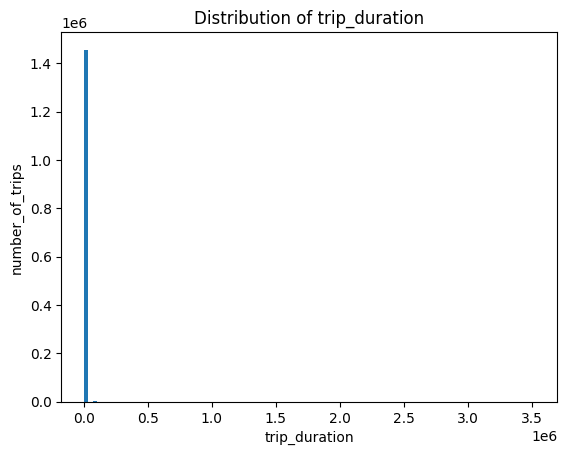

In [7]:
plt.hist(train_data['trip_duration'], bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number_of_trips')
plt.title('Distribution of trip_duration')
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

Предположительно целевая переменная распределена логнормально. Среди значений целевой переменной есть выбросы.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

Авторы не хотели, чтобы выбросы, которые присутствуют в данных судя по гистограмме, сильно влияли на
обучение модели. RMSE штрафует модель за неправильное предсказание по выбросам сильнее, чем RMSLE, так как в RMSLE от значений таргета и предсказаний дополнительно берется логарифм, что сильно уменьшает получающиеся значения.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**:
$$
\text{RMSLE}(X, y, a) = \\
|\hat{y}_i = \log{(y_i + 1)},\ a(x_i) = \exp(\hat{a}(x_i)) - 1| = \\
\sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \log{(\exp(\hat{a}(x_i)) - 1 + 1))}\big)^2} = \\
\sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \hat{a}(x_i)\big)^2} = \\
\text{RMSE}(X, \hat{y}, \hat{a})
$$
Оптимизация RMSE эквивалентна оптимизации MSE

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

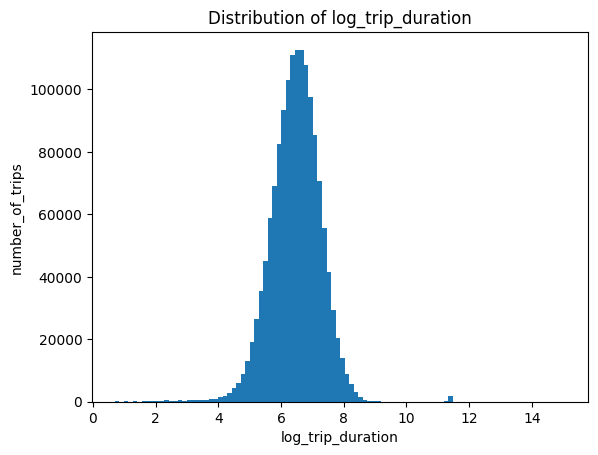

In [8]:
train_data['log_trip_duration'] = np.log1p(train_data['trip_duration'].values)
train_data.drop('trip_duration', axis=1, inplace=True)
                                          
plt.hist(train_data['log_trip_duration'], bins=100)
plt.xlabel('log_trip_duration')
plt.ylabel('number_of_trips')
plt.title('Distribution of log_trip_duration')
plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [9]:
def rmsle(log1p_y_true, log1p_y_pred):
    return np.sqrt(np.sum((log1p_y_true - log1p_y_pred)**2) / len(log1p_y_true))


# Поскольку оптимизация RMSLE эквивалентна оптимизации MSE, оптимум у RMSLE равен известному оптимуму MSE
log1p_y_pred = np.mean(train_data['log_trip_duration'])
rmsle_best_const = rmsle(train_data['log_trip_duration'], log1p_y_pred)
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411509


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году:

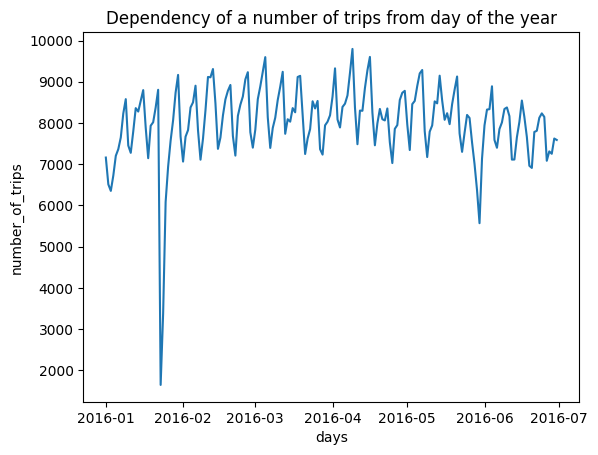

In [10]:
days = train_data['pickup_datetime'].dt.date.value_counts(sort=False).sort_index().index
number_of_trips = train_data['pickup_datetime'].dt.date.value_counts(sort=False).sort_index()
plt.xlabel('days')
plt.ylabel('number_of_trips')
plt.title('Dependency of a number of trips from day of the year')
plt.plot(days, number_of_trips)
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

In [11]:
number_of_trips[:30]

2016-01-01    7162
2016-01-02    6512
2016-01-03    6353
2016-01-04    6725
2016-01-05    7204
2016-01-06    7365
2016-01-07    7649
2016-01-08    8229
2016-01-09    8578
2016-01-10    7454
2016-01-11    7276
2016-01-12    7794
2016-01-13    8360
2016-01-14    8277
2016-01-15    8539
2016-01-16    8797
2016-01-17    7891
2016-01-18    7146
2016-01-19    7934
2016-01-20    8018
2016-01-21    8375
2016-01-22    8805
2016-01-23    1648
2016-01-24    3383
2016-01-25    6084
2016-01-26    6941
2016-01-27    7571
2016-01-28    8066
2016-01-29    8735
2016-01-30    9166
Name: pickup_datetime, dtype: int64

In [12]:
#Как видно, первым аномалальным периодом можно назвать 23-24 явнаря
first_anomaly = number_of_trips[22:24]
first_anomaly = pd.Series(first_anomaly.index.values, index=first_anomaly)

In [13]:
number_of_trips[-60:-30]

2016-05-02    7344
2016-05-03    8457
2016-05-04    8535
2016-05-05    8896
2016-05-06    9202
2016-05-07    9285
2016-05-08    7801
2016-05-09    7174
2016-05-10    7789
2016-05-11    7941
2016-05-12    8524
2016-05-13    8476
2016-05-14    9147
2016-05-15    8547
2016-05-16    8077
2016-05-17    8237
2016-05-18    7971
2016-05-19    8455
2016-05-20    8808
2016-05-21    9127
2016-05-22    7745
2016-05-23    7300
2016-05-24    7762
2016-05-25    8195
2016-05-26    8121
2016-05-27    7530
2016-05-28    7004
2016-05-29    6372
2016-05-30    5570
2016-05-31    7131
Name: pickup_datetime, dtype: int64

In [14]:
#Как видно, вторым аномалальным периодом можно назвать 30 мая
second_anomaly = number_of_trips[-32:-31]
second_anomaly = pd.Series(second_anomaly.index.values, index=second_anomaly)

Причина первой аномалии (https://en.wikipedia.org/wiki/January_2016_United_States_blizzard): \
"A travel ban was instituted for New York City and Newark, New Jersey, for January 23–24."\

Причина второй аномалии (https://print-a-calendar.com/holiday/memorial-day/2016, https://en.wikipedia.org/wiki/Memorial_Day): \
"Memorial Day endures as a holiday which most businesses observe" \
"Changing the date merely to create three-day weekends" \
30 мая 2016 в Нью-Йорке был выходной день, связанный с праздником Поминовения



Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках:

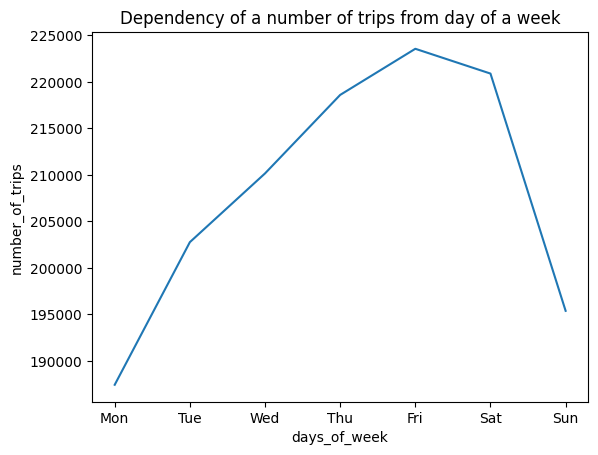

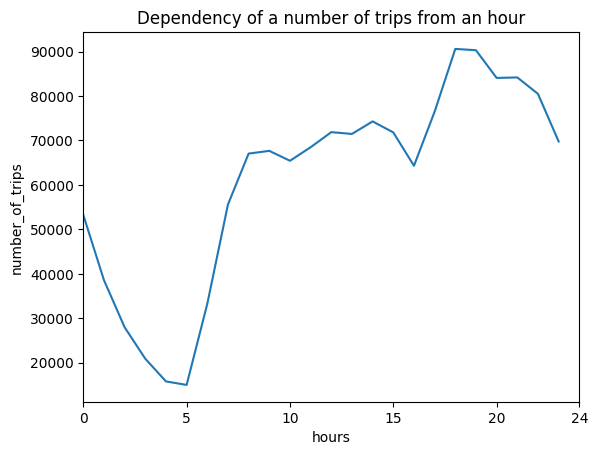

In [15]:
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
number_of_trips = train_data['pickup_datetime'].dt.dayofweek.value_counts(sort=False).sort_index()
plt.xlabel('days_of_week')
plt.ylabel('number_of_trips')
plt.title('Dependency of a number of trips from day of a week')
plt.plot(days_of_week, number_of_trips)
plt.show()

hours = np.arange(0, 24)
number_of_trips = train_data['pickup_datetime'].dt.hour.value_counts(sort=False).sort_index()
plt.xlabel('hours')
plt.ylabel('number_of_trips')
plt.title('Dependency of a number of trips from an hour')
plt.xlim([1, 24])
plt.xticks([0, 5, 10, 15, 20, 24])
plt.plot(hours, number_of_trips)
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, поищите, как это делается). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

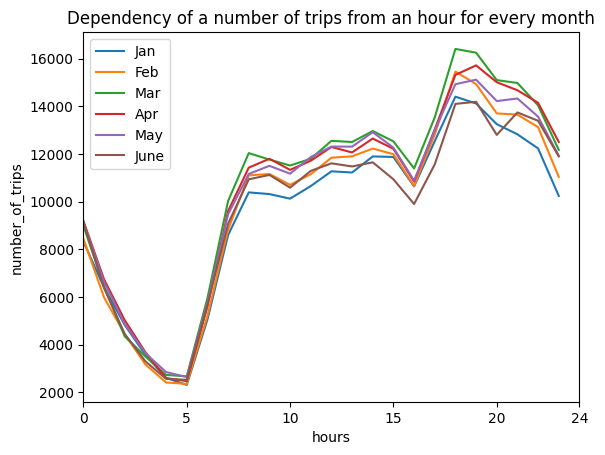

In [16]:
d = {'month' : train_data['pickup_datetime'].dt.month, 'hour' : train_data['pickup_datetime'].dt.hour}
trips_month_hour = pd.DataFrame(d)
number_of_trips_m_h = trips_month_hour.groupby(by=['month', 'hour']).value_counts().values.reshape((6, 24))

plt.xlabel('hours')
plt.ylabel('number_of_trips')
plt.title('Dependency of a number of trips from an hour for every month')
plt.xlim([1, 24])
plt.xticks([0, 5, 10, 15, 20, 24])

for number_of_trips in number_of_trips_m_h:
    plt.plot(hours, number_of_trips)
    
plt.legend(labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June'])
plt.show()

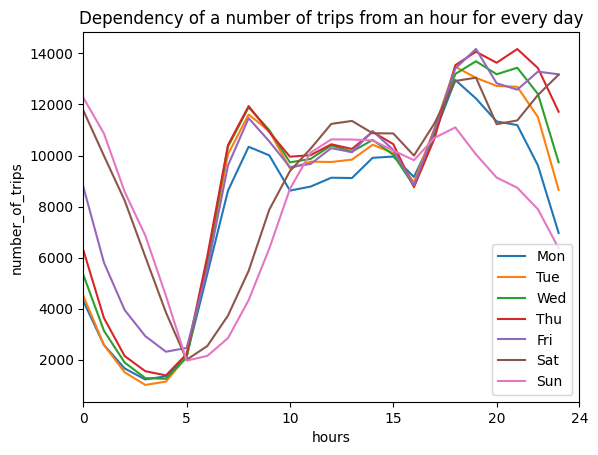

In [17]:
d = {'day' : train_data['pickup_datetime'].dt.dayofweek, 'hour' : train_data['pickup_datetime'].dt.hour}
trips_day_hour = pd.DataFrame(d)
number_of_trips_d_h = trips_day_hour.groupby(by=['day', 'hour']).value_counts().values.reshape((7, 24))

plt.xlabel('hours')
plt.ylabel('number_of_trips')
plt.title('Dependency of a number of trips from an hour for every day')
plt.xlim([1, 24])
plt.xticks([0, 5, 10, 15, 20, 24])

for number_of_trips in number_of_trips_d_h:
    plt.plot(hours, number_of_trips)
    
plt.legend(labels=days_of_week, loc='lower right')
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

Ответ на этот вопрос был частично сгенерирован с помощью GPT. В качестве промпта я использовал сам вопрос с прикрепленными графиками выше. После получения ответа попросил отправить его markdown-код. 

### Анализ графиков: зависимости числа поездок от времени суток, дней недели и месяцев

---

#### По месяцам (первый график):

1. **Часы с пиком активности**: 
   - Начиная с 5 утра, количество поездок резко возрастает, достигая пика между 7 и 9 часами утра. Это совпадает с началом рабочего дня.
   - Второй пик наблюдается между 16 и 18 часами, что связано с завершением рабочего дня.
   
2. **Ночные часы**: 
   - С 0 до 5 часов утра количество поездок снижается для всех месяцев, поскольку ночью люди спят.
   
2. **Месяцы с большим количеством поездок**: 
   - **Март** выделяется как месяц с наибольшим числом поездок в часы пиков.
   - **Январь** имеет минимальные показатели, вероятно из-за праздничного сезона и холодной погоды.
   
3. **Связь с сезонами**: 
   - Весенние месяцы, такие как март и апрель, демонстрируют большее количество поездок. Это может быть связано с улучшением погодных условий.

---

#### По дням недели (второй график):

1. **Выходные дни**:
   - В **воскресенье** и **cубботу** количество поездок с 5 до 10 часов утра значительно ниже, чем в рабочие дни. Это связано с тем, что в выходные дни людям как правило не нужно ехать на работу. В **воскресенье** наблюдается самая низкая активность среди всех дней, поскольку все отдыхают.
   
2. **Часы с пиком активности в рабочие дни**: 
   - Начиная с 5 утра, количество поездок резко возрастает, достигая пика между 7 и 9 часами утра. Это совпадает с началом рабочего дня.
   - Второй пик наблюдается между 16 и 18 часами, что связано с завершением рабочего дня..
   
3. **Рабочие дни**:
   - В рабочие дни поездки в среднем одинаково распределены.

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

1. Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок?\
Да, похожи
2. Почему?\
В дни или часы, когда количество поездок больше, дороги как правило более загружены, чем в дни, когда их меньше. Когда дороги более загружены, средняя продолжительность поездки растет (например, из-за заторов ДТП и тд), когда они свободы - она падает
3. Что происходит со средним таргетом в те два аномальных периода, что мы видели выше?\
В первый аномальный период средний таргет сильно увеличивается. Во второй аномальный период средний таргет сильно уменьшается.
4. Почему так происходит?\
В первый аномальный период средний таргет сильно увеличивается, поскольку в это время в Нью-Йорке были плохие погодные условия, из-за чего на дорогах могли образовываться заторы, что приводило к увеличению среднего времени поездки. Во второй аномальный период средний таргет сильно уменьшается, поскольку праздничный день (тем более День Поминовения) люди как правило проводят дома. Так как большинство людей остается дома, на дорогах становится меньше машин, соответственно, среднее время поездки уменьшается, поскольку нет заторов, ДТП и тд.
5. Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?\
Хотя средний таргет по дням года колеблется на всем графике, он в среднем увеличивается к концу июня.

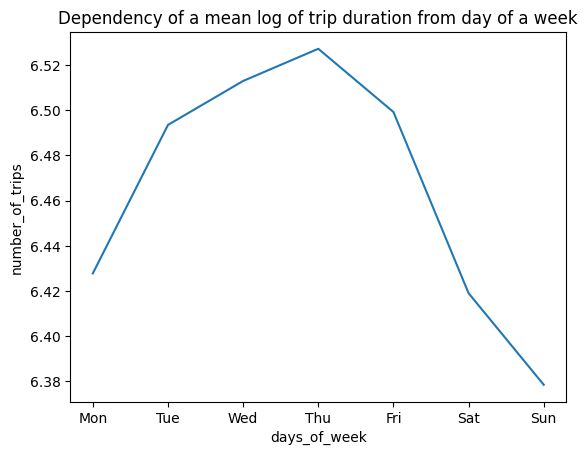

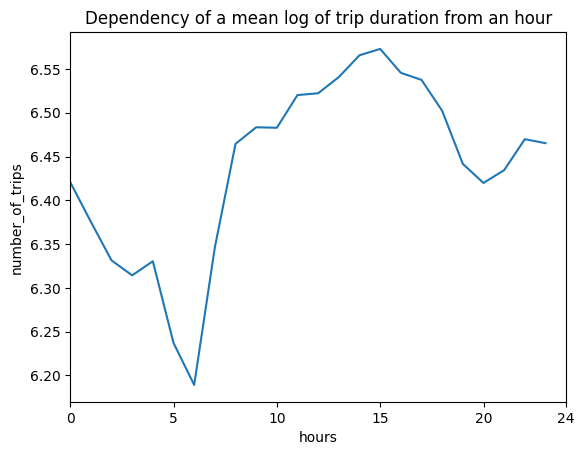

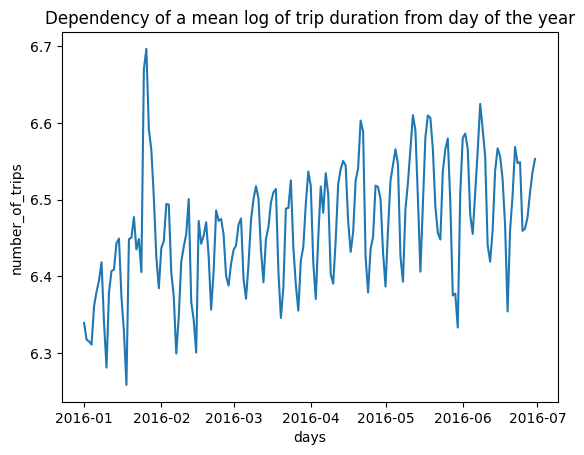

In [18]:
train, test = sklearn.model_selection.train_test_split(train_data, test_size=0.3, train_size=0.7,
                                                       random_state=sklearn_rnd_state)

mean__trip_dur_log_days_of_week = (train[['pickup_datetime', 'log_trip_duration']]
                                   .groupby(by=train['pickup_datetime'].dt.dayofweek)
                                   .mean(numeric_only=True))
mean_trip_dur_log_hours = (train[['pickup_datetime', 'log_trip_duration']]
                           .groupby(by=train['pickup_datetime'].dt.hour)
                           .mean(numeric_only=True))
mean_trip_dur_log_days_of_year= (train[['pickup_datetime', 'log_trip_duration']]
                           .groupby(by=train['pickup_datetime'].dt.date)
                           .mean(numeric_only=True))

plt.xlabel('days_of_week')
plt.ylabel('number_of_trips')
plt.title('Dependency of a mean log of trip duration from day of a week')
plt.plot(days_of_week, mean__trip_dur_log_days_of_week)
plt.show()

plt.xlabel('hours')
plt.ylabel('number_of_trips')
plt.title('Dependency of a mean log of trip duration from an hour')
plt.xlim([1, 24])
plt.xticks([0, 5, 10, 15, 20, 24])
plt.plot(hours, mean_trip_dur_log_hours)
plt.show()

plt.xlabel('days')
plt.ylabel('number_of_trips')
plt.title('Dependency of a mean log of trip duration from day of the year')
plt.plot(days, mean_trip_dur_log_days_of_year)
plt.show()

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [19]:
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek
train['month'] = train['pickup_datetime'].dt.month
train['hour'] = train['pickup_datetime'].dt.hour
train['is_first_anomaly'] = train['pickup_datetime'].dt.date.isin(first_anomaly).astype(float)
train['is_second_anomaly'] = train['pickup_datetime'].dt.date.isin(second_anomaly).astype(float)
train['day_of_year'] = train['pickup_datetime'].dt.dayofyear

test['day_of_week'] = test['pickup_datetime'].dt.dayofweek
test['month'] = test['pickup_datetime'].dt.month
test['hour'] = test['pickup_datetime'].dt.hour
test['is_first_anomaly'] = test['pickup_datetime'].dt.date.isin(first_anomaly).astype(float)
test['is_second_anomaly'] = test['pickup_datetime'].dt.date.isin(second_anomaly).astype(float)
test['day_of_year'] = test['pickup_datetime'].dt.dayofyear

In [20]:
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,day_of_week,month,hour,is_first_anomaly,is_second_anomaly,day_of_year
74271,id1857802,1,2016-03-06 18:40:48,1,-73.987137,40.754986,-73.979912,40.739620,N,6.563856,6,3,18,0.0,0.0,66
484810,id3469745,2,2016-01-11 13:54:39,1,-73.994438,40.726185,-73.981148,40.728168,N,6.248043,0,1,13,0.0,0.0,11
366156,id1169637,2,2016-01-10 23:31:31,2,-73.954330,40.764042,-73.982750,40.761539,N,6.622736,6,1,23,0.0,0.0,10
1249224,id3405481,1,2016-05-29 23:08:13,1,-73.967361,40.760460,-73.955055,40.777298,N,5.393628,6,5,23,0.0,0.0,150
887060,id2578324,2,2016-05-13 23:57:05,1,-73.976639,40.743713,-73.981789,40.720963,N,6.077642,4,5,23,0.0,0.0,134


Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

Ответ на этот вопрос был частично получен с помощью GPT. Промпт:\
"Which features of the following:\
id                            object\
vendor_id                      int64\
pickup_datetime       datetime64[ns]\
passenger_count                int64\
pickup_longitude             float64\
pickup_latitude              float64\
dropoff_longitude            float64\
dropoff_latitude             float64\
store_and_fwd_flag            object\
log_trip_duration            float64\
day_of_week                    int64\
month                          int64\
hour                           int64\
is_first_anomaly             float64\
is_second_anomaly            float64\
day_of_year                    int64\
should be used as categorical and which should be used as numerical If we want to apply regression to predict log_trip_duration? Provide full explanation for each feature. Write your answer in Russian in a format of markdown code"

### **Категориальные признаки:**

1. **`vendor_id` (int64)**:
   - **Категориальный**: этот признак представляет ID поставщика услуг (например, такси). Несмотря на то, что это целое число, оно не является непрерывной числовой переменной; ID поставщика услуг не могут быть упорядочены. Каждый поставщик — это отдельная категория.


2. **`store_and_fwd_flag` (object)**:
   - **Категориальный**: Этот флаг указывает, была ли информация о поездке сохранена и передана позже (например, "Y" или "N"). Это четкие категории, а не числовые значения, представляющие дискретное свойство каждой поездки.

3. **`day_of_week` (int64)**:
   - **Категориальный**: Представляет день недели (например, 0 для понедельника, 1 для вторника). Дни недели нельзя осмысленно упорядочить (например, из-за их цикличности), поэтому этот признак лучше обрабатывать как категориальный.

4. **`month` (int64)**:
   - **Категориальный**: Месяц (1–12) можно считать числовым признаком, но лучше обрабатывать его как категориальный, поскольку месяцы цикличны (например, декабрь сменяется январем), вследствие чего их нельзя осмысленно упорядочить.
   
5. **`hour` (int64)**:
   - **Категориальный**: Этот признак представляет час дня (0–23). Поскольку часы цикличны, их нельзя осмысленно упорядочить, значит, этот признак следует сделать категориальным.

6. **`day_of_year` (int64)**:
   - **Категориальный**: Это номер дня в году (1–365). Как и с месяцами, его лучше рассматривать как категориальный признак, так как он цикличен и не является непрерывной переменной.
   
7. **`is_first_anomaly` и `is_second_anomaly` (float64)**:
   - **Категориальный**: Эти признаки указывают на наличие аномалий в поездке. Они представляют собой бинарные признаки, которые кодируются как числовые (1 или 0), но сами по себе признаки являются категориальными, поскольку относят поездку к одной из трех категорий: не аномальная, с первой аномалией, со второй аномалией.

### **Числовые признаки:**

1. **`pickup_datetime` (datetime64[ns])**:
   - **Числовой** (после извлечения): Этот признак сам по себе не используется в модели. Однако из него извлекаются числовые признаки, такие как `hour`, `day_of_week`, и `day_of_year`.

2. **`passenger_count` (int64)**:
   - **Числовой**: Количество пассажиров является дискретной целочисленной переменной, которая влияет на продолжительность поездки (например, больше пассажиров — больше времени на посадку). Его следует рассматривать как числовой признак.

3. **`pickup_longitude` и `pickup_latitude` (float64)**:
   - **Числовой**: Эти признаки представляют географические координаты точки отправления и являются непрерывными числовыми значениями. Они могут быть использованы для расчета расстояний или других пространственных признаков.

4. **`dropoff_longitude` и `dropoff_latitude` (float64)**:
   - **Числовой**: Эти признаки аналогичны координатам точки отправления, но представляют место высадки. Они также являются непрерывными величинами и могут использоваться для расчета расстояния между точками.

### **Ни категориальные, ни числовые:**

1. **`id` (object)**:
   - **Исключить**: Это уникальный идентификатор для каждой поездки. Он не содержит полезной информации для предсказания и должен быть исключен из модели.

### **Сводка:**

- **Категориальные признаки**: `vendor_id`, `store_and_fwd_flag`, `day_of_week`, `month`, `day_of_year`.
- **Числовые признаки**: `passenger_count`, `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`, `hour`, `is_first_anomaly`, `is_second_anomaly`.
- **Исключить**: `pickup_datetime`, `id` (уникальный идентификатор).


**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [21]:
X_train = train[['day_of_week', 'month', 'hour', 'is_first_anomaly', 'is_second_anomaly', 'day_of_year']]
X_test = test[['day_of_week', 'month', 'hour', 'is_first_anomaly', 'is_second_anomaly', 'day_of_year']]
Y_train = train['log_trip_duration']
Y_test = test['log_trip_duration']
categorical = ['day_of_week', 'month', 'day_of_year', 'hour']
numeric_features = ['is_first_anomaly', 'is_second_anomaly']
#Здесь я добавил is_first_anomaly и is_second_anomaly в массив категориальных признаков, поскольку к ним
#уже применено OHE

column_transformer = ColumnTransformer ([
    ('ohe', OneHotEncoder (handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
pipeline = Pipeline(steps=[
(' ohe_and_scaling', column_transformer),
(' regression', Ridge())
])

model = pipeline.fit(X_train, Y_train)
y_pred = model.predict(X_test)
print(f'RMSLE: {rmsle(Y_test, y_pred)}')

RMSLE: 0.788580200998923


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [22]:
from typing import Iterable

def show_circles_on_map(
    latitude_values: Iterable[float],
    longitude_values: Iterable[float],
    color: str = "blue",
) -> folium.Map:
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    Works best on samples of size < 10k, too costly otherwise

    latitude_values: sample latitude values of a dataframe
    longitude_column: sample longitude values of a dataframe
    color: the color of circles to be drawn
    """

    location = (np.mean(latitude_values), np.mean(longitude_values))
    m = folium.Map(location=location)

    for lat, lon in zip(latitude_values, longitude_values):
        folium.Circle(
            radius=100,
            location=(lat, lon),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

Напишите функция, которая вернет значения колонок `pickup_latitude`, `pickup_longitude` на каком-нибудь разумном кусочке датафрейма, например, `df.sample(1000)` и покажите на карте, используя `show_circles_on_map`

In [81]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
your_lat_values = train.sample(1000)['pickup_latitude']
your_lon_values = train.sample(1000)['pickup_longitude']

show_circles_on_map(your_lat_values, your_lon_values, color="midnightblue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

Ответ на данный вопрос частично сгенерирован с помощью GPT. В качестве входной информации я скинул скриншот карты и вопрос задания.

На карте выделяются 2 кластера на востоке карты (справа от основного скопления), и один кластер на юге карты (снизу от основного скопления). Эти кластеры могут быть полезны для задачи, поскольку зависимость длительности поездки из них от признаков может иметь иной характер (в силу удаленности этих кластеров), нежели эта зависимость у поездок из основного скопления, и если это принять во внимание (добавив соответствующие признаки), можно улучшить качество модели.
Я выбрал эти кластеры, поскольку они явно отделены от основной группы точек.
Особенность этих скоплений для нашей задачи заключается в их удалённости. Удаленность может указывать на уникальные или специфические события, объекты или особенности этих мест, принимая во внимание которые можно улучшить качество модели. При этом в каждом из выделенных кластеров находится достаточное количество точек, для того чтобы выделять их в отдельные категории.

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [24]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


In [25]:
train['haversine'] = train.apply(lambda row : haversine_array(row['pickup_latitude'], row['pickup_longitude'],
                                                              row['dropoff_latitude'], row['dropoff_longitude']),
                                 axis=1)
test['haversine'] = test.apply(lambda row : haversine_array(row['pickup_latitude'], row['pickup_longitude'],
                                                              row['dropoff_latitude'], row['dropoff_longitude']),
                                 axis=1)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [26]:
train['log_haversine'] = np.log1p(train['haversine'].values)
test['log_haversine'] = np.log1p(test['haversine'].values)

Посчитайте корреляцию и убедитесь, что логарифм расстояния лучше отражает таргет, чем просто расстояние:

In [27]:
train[['haversine', 'log_trip_duration']].corr()

,haversine,log_trip_duration
haversine,1.000000,0.572923
log_trip_duration,0.572923,1.000000


In [28]:
train[['log_haversine', 'log_trip_duration']].corr()

,log_haversine,log_trip_duration
log_haversine,1.000000,0.749925
log_trip_duration,0.749925,1.000000


**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

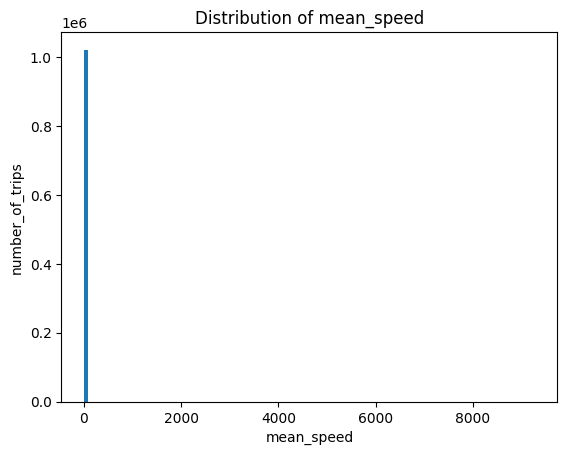

In [29]:
train['mean_speed'] = train['haversine'].values / (np.exp(train['log_trip_duration'].values) - 1) * 3600
#speed in km/h
plt.hist(train['mean_speed'], bins=100)
plt.xlabel('mean_speed')
plt.ylabel('number_of_trips')
plt.title('Distribution of mean_speed')
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

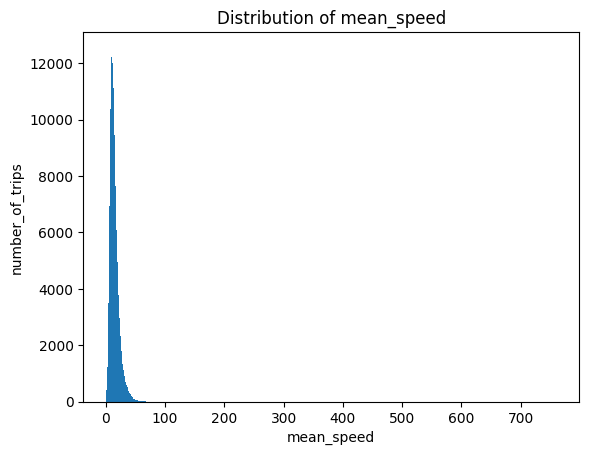

In [30]:
# Воспользуемся правилом трех сигм

plt.hist(train['mean_speed'][train['mean_speed']<= 3 * train['mean_speed'].var()], bins='auto')
plt.xlabel('mean_speed')
plt.ylabel('number_of_trips')
plt.title('Distribution of mean_speed')
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте Heatmap-график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

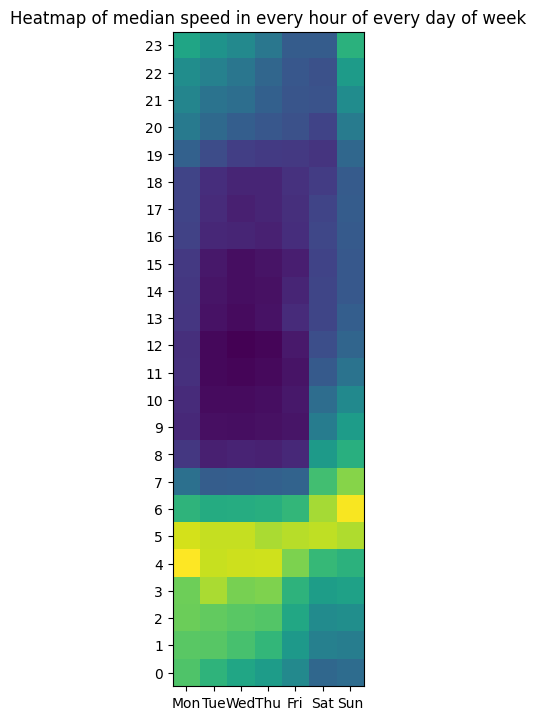

In [31]:
median_speed = np.flip(train[['day_of_week', 'hour', 'mean_speed']]
                       .groupby(by=['day_of_week', 'hour'])
                       .median()
                       .values
                       .reshape(7, 24)
                       .T,
                       axis=0)
plt.figure(figsize=(3,8.5))
plt.yticks(np.arange(-1, 25), labels=np.arange(24, -2, -1))
plt.xticks(np.arange(7), labels=days_of_week)
plt.title('Heatmap of median speed in every hour of every day of week')
plt.imshow(median_speed)
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

Значение скорости нельзя использовать во время обучения, поскольку для его вычисления мы воспользовались значением целевой переменной, то есть если его использовать, произойдет утечка целевой переменной в обучающие данные, в результате чего модель может переобучиться.

In [32]:
train.drop(labels=['mean_speed'], axis=1, inplace=True)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Сскорость максимальна в 4-6 часов утра. Скорость минимальна с 9 до 12 часов во все дни.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [33]:
# По хитмапу медианной скорости видно, что дороги свободны в 4-6 утра, а пробки наблюдаются с 8 до 18 часов
train['is_free_roads_period'] = train['hour'].between(4, 6).astype('float')
train['is_jam_period'] = train['hour'].between(8, 18).astype('float')
test['is_free_roads_period'] = test['hour'].between(4, 6).astype('float')
test['is_jam_period'] = test['hour'].between(8, 18).astype('float')

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

In [34]:
def trips_in_neighbourhood(trips_data, cluster, neigh_сoords):
    #neigh_coords[0] = left lowest point of neigh rectangle
    #neigh_coords[1] = right highest point of neigh rectangle
    for coord_type in ['pickup', 'dropoff']:
        trips_data[f'{coord_type}_{cluster}'] = (trips_data[f'{coord_type}_longitude']
                                                                .between(neigh_coords[0][0],
                                                                         neigh_coords[1][0]) &
                                                                trips_data[f'{coord_type}_latitude']
                                                                .between(neigh_coords[0][1],
                                                                         neigh_coords[1][1])
                                                ).astype('float')                                              
    return


neigh_coords = [[-74.021975, 40.640846], [-73.962176, 40.654917]]
trips_in_neighbourhood(train, 'lowest_cluster', neigh_coords)
trips_in_neighbourhood(test, 'lowest_cluster', neigh_coords)
neigh_coords = [[-73.882136, 40.728792], [-73.856253, 40.772457]]
trips_in_neighbourhood(train, 'first_right_cluster', neigh_coords)
trips_in_neighbourhood(test, 'first_right_cluster', neigh_coords)
neigh_coords = [[-73.796201, 40.718778], [-73.771247, 40.788893]]
trips_in_neighbourhood(train, 'second_right_cluster', neigh_coords)
trips_in_neighbourhood(test, 'second_right_cluster', neigh_coords)

Для каждого из созданных признаков нарисуйте "ящик с усами" (aka boxplot) распределения логарифма времени поездки

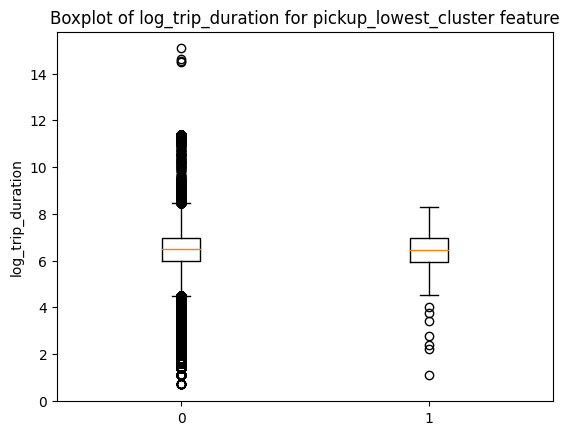

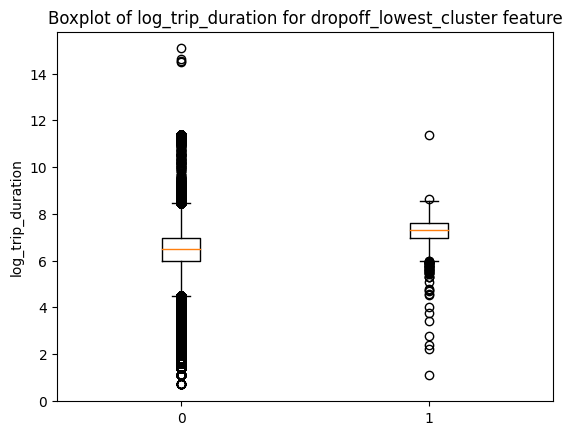

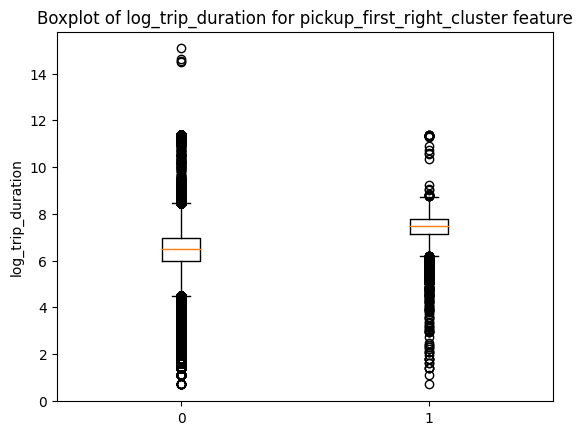

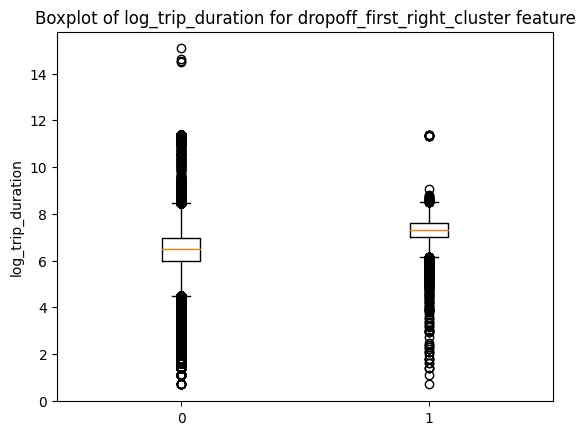

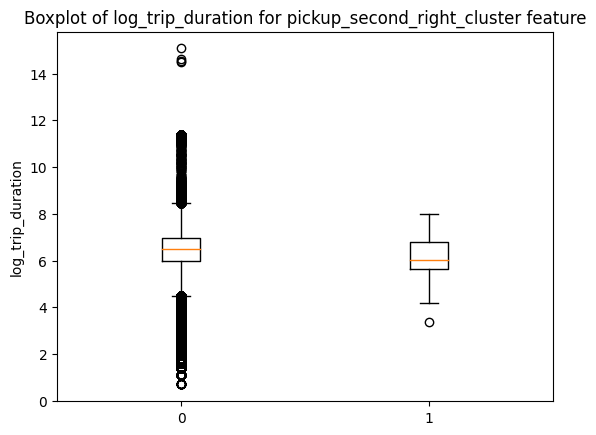

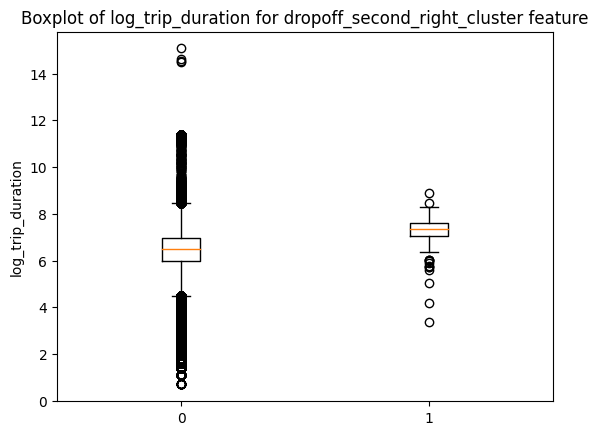

In [35]:
for cluster in ['lowest_cluster', 'first_right_cluster', 'second_right_cluster']:
    for coord_type in ['pickup', 'dropoff']:
        plt.boxplot([train['log_trip_duration'][train[f'{coord_type}_{cluster}'] == 0.0],
                     train['log_trip_duration'][train[f'{coord_type}_{cluster}'] == 1.0]],
                    labels=[0,1])
        plt.ylabel('log_trip_duration')
        plt.title(f'Boxplot of log_trip_duration for {coord_type}_{cluster} feature')
        plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

Признаки получились хорошими, поскольку поездки, закончившиеся и (или) начавшиеся в выделенных кластерах, обладают достаточной специфичностью распределения логарифма времени поездки по сравнению с остальными данными. Это выражается в том, что box логарифма времени поездки для поездок не из кластера находится на другом уровне и имеет другой IQR по сравнению с box логарифма времени поездки для поездок из кластера, а также в том, что количество и расположение точек-выбросов логарифма времени поездки отличается у поездок из кластера и не из кластера.


<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, ncell_lat, ncell_long, left_bottom_point_of_cluster, right_top_point_of_cluster):
        self.ncell_lat = ncell_lat #lat = height, long = width
        self.ncell_long = ncell_long
        self.left_bottom_point_of_cluster = left_bottom_point_of_cluster
        self.right_top_point_of_cluster = right_top_point_of_cluster
        self.grid = []
        pass

    def show_map(self):
        location = [40.675985, -73.940539] #format: lat long
        m = folium.Map(location=location)
        for point_idx in range(len(self.grid) - 1):
            if (point_idx == 0 or ((point_idx + 1) % (self.ncell_lat)) != 0):
                line = folium.PolyLine([self.grid[point_idx], self.grid[point_idx + 1]],
                                       color='red',
                                       line_weight=5)
                line.add_to(m)
            if (point_idx + self.ncell_long + 1 < len(self.grid)):
                line = folium.PolyLine([self.grid[point_idx], self.grid[point_idx + self.ncell_long + 1]],
                                       color='red',
                                       line_weight=5)
            line.add_to(m)
        return m

    def fit(self, X=None, y=None):
        self.grid = []
        min_long = self.left_bottom_point_of_cluster[1]
        max_long = self.right_top_point_of_cluster[1]
        min_lat = self.left_bottom_point_of_cluster[0]
        max_lat = self.right_top_point_of_cluster[0]
        lat_step = (min_lat - max_lat) / self.ncell_lat
        long_step = (max_long - min_long) / self.ncell_long
        for n_lat_step in range(self.ncell_lat + 1):
            for n_long_step in range(self.ncell_long + 1):
                self.grid.append((max_lat + n_lat_step * lat_step, min_long + n_long_step * long_step))
        return self

    def transform(self, X, y=None):
        X_new = X.copy()
        X_new['ncell_pickup'] = -1
        X_new['ncell_dropoff'] = -1
        cell_idx = 0
        for point_idx in range(self.ncell_lat * (self.ncell_long + 1)):
            if point_idx % self.ncell_lat == 0:
                continue
            for coord_type in ['pickup', 'dropoff']:
                X_new.loc[X_new[f'{coord_type}_longitude']
                          .between(self.grid[point_idx + self.ncell_long][1],
                                   self.grid[point_idx][1],
                                   inclusive='neither') &
                          X_new[f'{coord_type}_latitude']
                          .between(self.grid[point_idx + self.ncell_long][0],
                                   self.grid[point_idx][0],
                                   inclusive='neither'),
                          f'ncell_{coord_type}'
                         ] = cell_idx
            cell_idx += 1
        return X_new

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [40]:
mgt = MapGridTransformer(4, 3, [40.702697, -74.020122], [40.793418, -73.933800])
mgt.fit(train)
train = mgt.transform(train)
mgt.fit(test)
test = mgt.transform(test)

In [41]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'log_trip_duration',
       'day_of_week', 'month', 'hour', 'is_first_anomaly', 'is_second_anomaly',
       'day_of_year', 'haversine', 'log_haversine', 'is_free_roads_period',
       'is_jam_period', 'pickup_lowest_cluster', 'dropoff_lowest_cluster',
       'pickup_first_right_cluster', 'dropoff_first_right_cluster',
       'pickup_second_right_cluster', 'dropoff_second_right_cluster',
       'ncell_pickup', 'ncell_dropoff'],
      dtype='object')

In [42]:
X_train = train[['day_of_week', 'month', 'hour', 'is_first_anomaly', 'is_second_anomaly', 'day_of_year',
                 'haversine', 'log_haversine', 'is_free_roads_period', 'is_jam_period', 'pickup_lowest_cluster',
                 'dropoff_lowest_cluster', 'pickup_first_right_cluster', 'dropoff_first_right_cluster',
                 'pickup_second_right_cluster', 'dropoff_second_right_cluster', 'ncell_pickup', 'ncell_dropoff']]
X_test = test[['day_of_week', 'month', 'hour', 'is_first_anomaly', 'is_second_anomaly', 'day_of_year',
               'haversine', 'log_haversine', 'is_free_roads_period', 'is_jam_period', 'pickup_lowest_cluster',
               'dropoff_lowest_cluster', 'pickup_first_right_cluster', 'dropoff_first_right_cluster',
               'pickup_second_right_cluster', 'dropoff_second_right_cluster', 'ncell_pickup', 'ncell_dropoff']]
Y_train = train['log_trip_duration']
Y_test = test['log_trip_duration']
categorical = ['day_of_week', 'month', 'day_of_year', 'hour', 'ncell_pickup', 'ncell_dropoff']
numeric_features = ['is_first_anomaly', 'is_second_anomaly', 'haversine', 'log_haversine',
                    'is_free_roads_period', 'is_jam_period', 'pickup_lowest_cluster',
                    'dropoff_lowest_cluster', 'pickup_first_right_cluster', 'dropoff_first_right_cluster',
                    'pickup_second_right_cluster', 'dropoff_second_right_cluster']

'''
Здесь я добавил 'is_first_anomaly', 'is_second_anomaly', 'haversine', 'log_haversine', 'is_free_roads_period',
'is_jam_period', 'pickup_lowest_cluster', 'dropoff_lowest_cluster', 'pickup_first_right_cluster',
'dropoff_first_right_cluster', 'pickup_second_right_cluster', 'dropoff_second_right_cluster'
в массив категориальных признаков, поскольку к ним уже применено OHE
'''

column_transformer = ColumnTransformer ([
    ('ohe', OneHotEncoder (handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
pipeline = Pipeline(steps=[
(' ohe_and_scaling', column_transformer),
(' regression', Ridge())
])

model = pipeline.fit(X_train, Y_train)
y_pred = model.predict(X_test)
print(f'RMSLE: {rmsle(Y_test, y_pred)}')

RMSLE: 0.47437723820827843


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Ответ на этот вопрос был частично сгенерирован с помощью GPT. Промптом служил вопрос задания, но я общался в контексте диалога со всеми моими предыдущими вопросами к GPT по этому ДЗ.

Каждый из этих признаков может быть потенциально полезным для анализа и прогнозирования по следующим причинам:

### 1. **vendor_id**
   - **Почему полезен**:
     - Признак - id поставщика услуг такси. Разные поставщики такси могут иметь различия в качестве обслуживания, маршрутах или даже в тарифах, что может влиять на продолжительность поездки.

### 2. **passenger_count**
   - **Почему полезен**:
     - Количество пассажиров может влиять на продолжительность поездки, поскольку большему числу пассажиров вероятнее может понадобиться остановиться в нескольких пунктах по ходу поездки.

### 3. **store_and_fwd_flag**
   - **Почему полезен**:
     - Признак указывает, была ли информация о поездке передана в реальном времени или сохранена для отправки позже. Это может быть индикатором работы в зонах с плохим сигналом, то есть поездок в удаленные районы, длительность которых как правило больше длительности обычных поездок. Кроме того, этот признак может указывать на неполадки со связью, вызванные плохими погодными условиями, а плохие погодные условия увеличивают продолжительность поездки.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [43]:
print(f'Number of unique values of vendor_id: {train_data["vendor_id"].nunique()}')
print(f'Number of unique values of passenger_count: {train_data["passenger_count"].nunique()}')
print(f'Number of unique values of store_and_fwd_flag: {train_data["store_and_fwd_flag"].nunique()}')

Number of unique values of vendor_id: 2
Number of unique values of passenger_count: 10
Number of unique values of store_and_fwd_flag: 2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

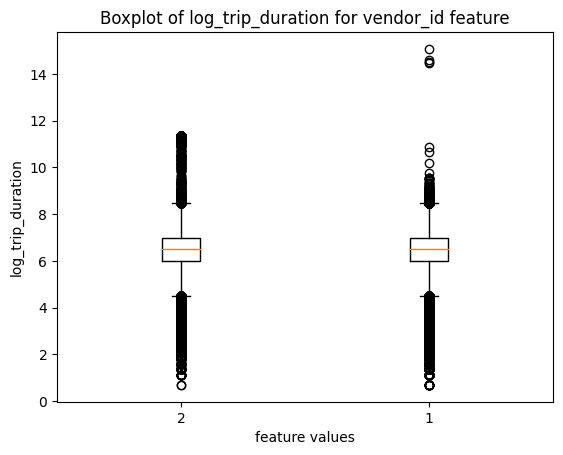

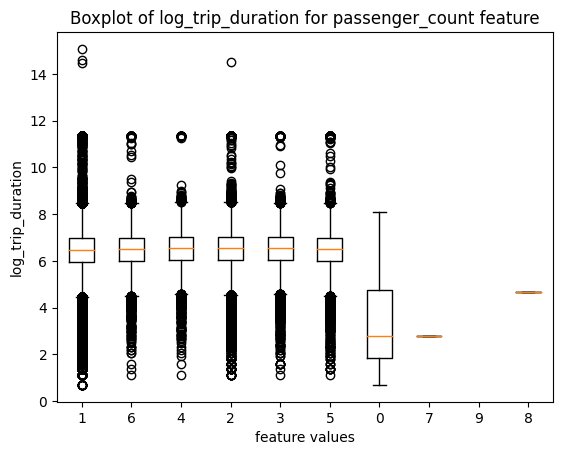

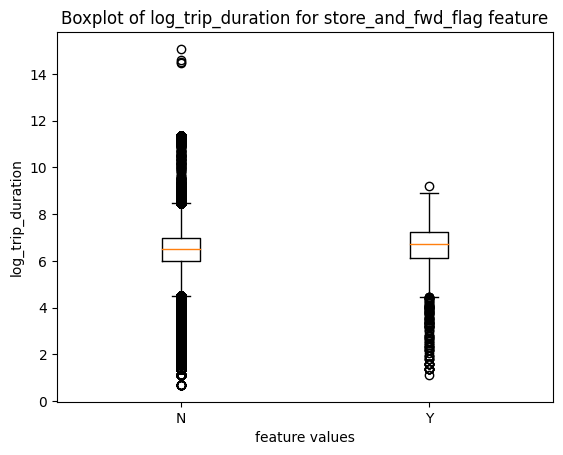

In [44]:
for feature in ['vendor_id', 'passenger_count', 'store_and_fwd_flag']:
    log_trip_durations = []
    labels = train_data[feature].unique()
    for value in labels:
        log_trip_durations.append(train['log_trip_duration'][train[feature] == value])
    plt.boxplot(log_trip_durations, labels=labels)
    plt.ylabel('log_trip_duration')
    plt.xlabel('feature values')
    plt.title(f'Boxplot of log_trip_duration for {feature} feature')
    plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [45]:
train['vendor_id'] = pd.get_dummies(train['vendor_id'], dtype=float)[1]
test['vendor_id'] = pd.get_dummies(test['vendor_id'], dtype=float)[1]
train['store_and_fwd_flag'] = pd.get_dummies(train['store_and_fwd_flag'], dtype=float)['Y']
test['store_and_fwd_flag'] = pd.get_dummies(test['store_and_fwd_flag'], dtype=float)['Y']

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?
Думаю, что признаки не будут сильными, поскольку для всех их значений разброс логарифма времени поездки очень высок (много выбросов), а также потому, что для большинства значений IQR логарифма времени поездки находится на одном уровне и имеет одинаковую длину, то есть специфичность в зависимости от значения как правило небольшая

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [46]:
X_train = train[['vendor_id', 'store_and_fwd_flag', 'day_of_week', 'month', 'hour',
                 'is_first_anomaly', 'is_second_anomaly', 'day_of_year',
                 'haversine', 'log_haversine', 'is_free_roads_period', 'is_jam_period', 'pickup_lowest_cluster',
                 'dropoff_lowest_cluster', 'pickup_first_right_cluster', 'dropoff_first_right_cluster',
                 'pickup_second_right_cluster', 'dropoff_second_right_cluster', 'ncell_pickup', 'ncell_dropoff']]
X_test = test[['vendor_id', 'store_and_fwd_flag', 'day_of_week', 'month',
               'hour', 'is_first_anomaly', 'is_second_anomaly', 'day_of_year',
               'haversine', 'log_haversine', 'is_free_roads_period', 'is_jam_period', 'pickup_lowest_cluster',
               'dropoff_lowest_cluster', 'pickup_first_right_cluster', 'dropoff_first_right_cluster',
               'pickup_second_right_cluster', 'dropoff_second_right_cluster', 'ncell_pickup', 'ncell_dropoff']]
Y_train = train['log_trip_duration']
Y_test = test['log_trip_duration']
categorical = ['day_of_week', 'month', 'day_of_year', 'hour', 'ncell_pickup', 'ncell_dropoff']
numeric_features = ['vendor_id', 'store_and_fwd_flag', 'is_first_anomaly', 'is_second_anomaly', 'haversine',
                    'log_haversine',
                    'is_free_roads_period', 'is_jam_period', 'pickup_lowest_cluster',
                    'dropoff_lowest_cluster', 'pickup_first_right_cluster', 'dropoff_first_right_cluster',
                    'pickup_second_right_cluster', 'dropoff_second_right_cluster']

'''
Здесь я добавил 'vendor_id', 'store_and_fwd_flag', 'is_first_anomaly', 'is_second_anomaly',
'haversine', 'log_haversine',
'is_free_roads_period', 'is_jam_period', 'pickup_lowest_cluster', 'dropoff_lowest_cluster',
'pickup_first_right_cluster', 'dropoff_first_right_cluster', 'pickup_second_right_cluster',
'dropoff_second_right_cluster'
в массив категориальных признаков, поскольку к ним уже применено OHE
'''

column_transformer = ColumnTransformer ([
    ('ohe', OneHotEncoder (handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
pipeline = Pipeline(steps=[
(' ohe_and_scaling', column_transformer),
(' regression', Ridge())
])

model = pipeline.fit(X_train, Y_train)
y_pred = model.predict(X_test)
print(f'RMSLE: {rmsle(Y_test, y_pred)}')

RMSLE: 0.4742330521614986


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

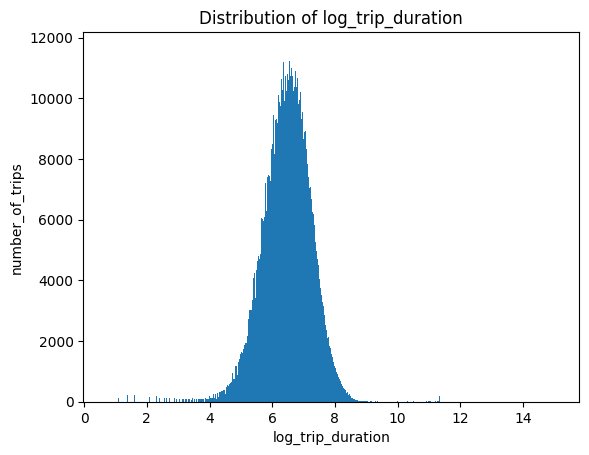

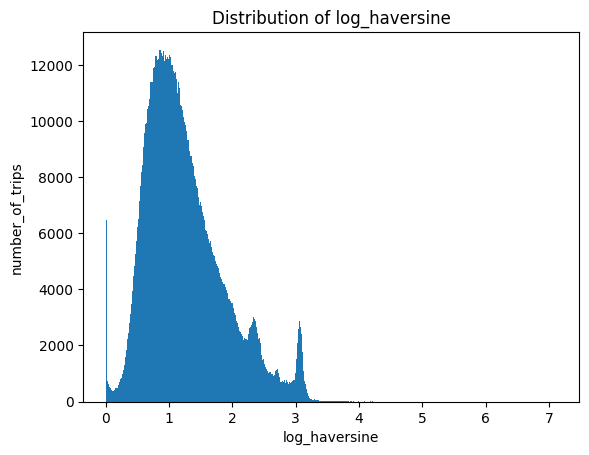

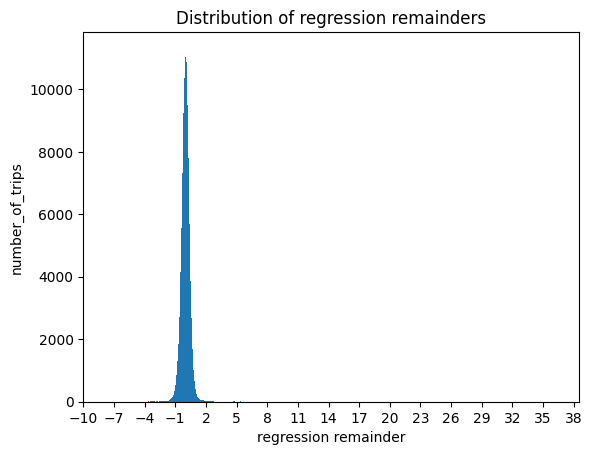

In [47]:
plt.hist(Y_train, bins='auto')
plt.xlabel('log_trip_duration')
plt.ylabel('number_of_trips')
plt.title('Distribution of log_trip_duration')
plt.show()

plt.hist(X_train['log_haversine'], bins='auto')
plt.xlabel('log_haversine')
plt.ylabel('number_of_trips')
plt.title('Distribution of log_haversine')
plt.show()

plt.hist(Y_train - model.predict(X_train), bins='auto')
plt.xlabel('regression remainder')
plt.xticks(np.arange(-10, 40, 3))
plt.ylabel('number_of_trips')
plt.title('Distribution of regression remainders')
plt.show()

In [48]:
y_pred = model.predict(X_train)
train = train[(Y_train - y_pred).between(-1.25, 1.25)]
train = train[train['log_trip_duration'].between(4, 8.15)]
train = train[train['log_haversine'].between(0, 3.25)]

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [49]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'log_trip_duration',
       'day_of_week', 'month', 'hour', 'is_first_anomaly', 'is_second_anomaly',
       'day_of_year', 'haversine', 'log_haversine', 'is_free_roads_period',
       'is_jam_period', 'pickup_lowest_cluster', 'dropoff_lowest_cluster',
       'pickup_first_right_cluster', 'dropoff_first_right_cluster',
       'pickup_second_right_cluster', 'dropoff_second_right_cluster',
       'ncell_pickup', 'ncell_dropoff'],
      dtype='object')

In [50]:
train.drop(labels=['id'], axis=1, inplace=True)
test.drop(labels=['id'], axis=1, inplace=True)
# Поскольку каждый id уникален, все его значения являются редкими. Объединять их в одно смысла нет, проще
# удалить колонку (иначе будет колонка из одного и того же значения)

In [51]:
train.drop(labels=['pickup_datetime'], axis=1, inplace=True)
test.drop(labels=['pickup_datetime'], axis=1, inplace=True)
# pickup_datetime показывает время начало поездки с точности до секунды. Очевидно, что все значения этого признака 
# будут достаточно редкими. Кроме того, мы извлекли из этого признака все значимые данные в другие признаки
# (hour, day_of_week, day_of_year, month). Так что этот признак следует удалить

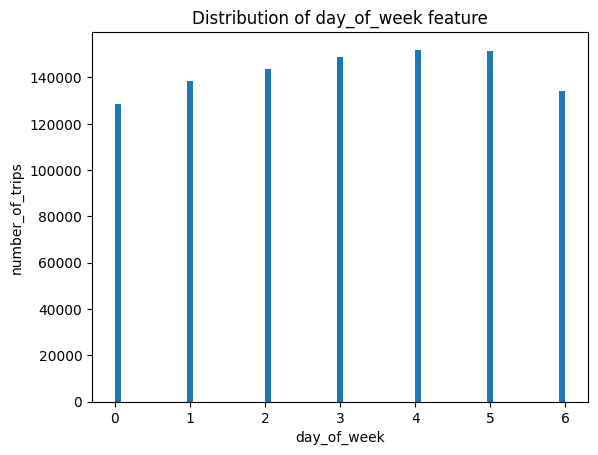

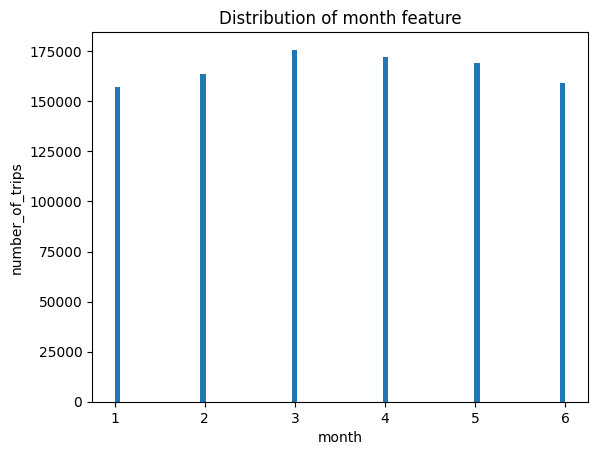

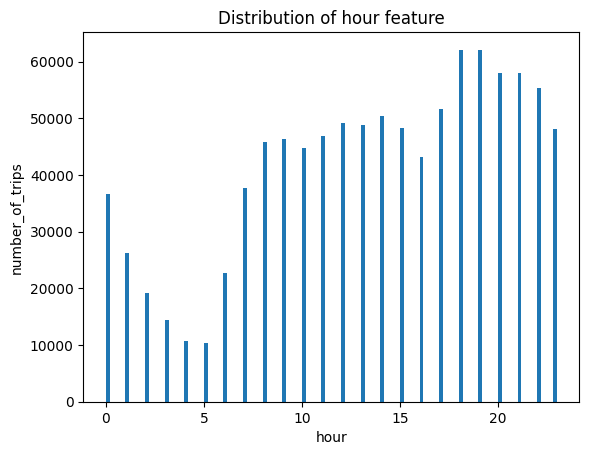

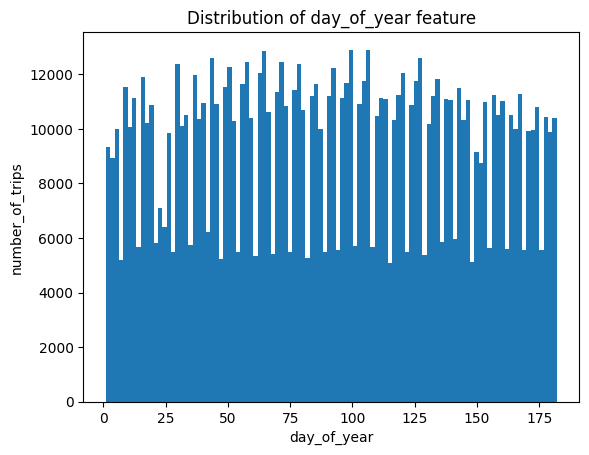

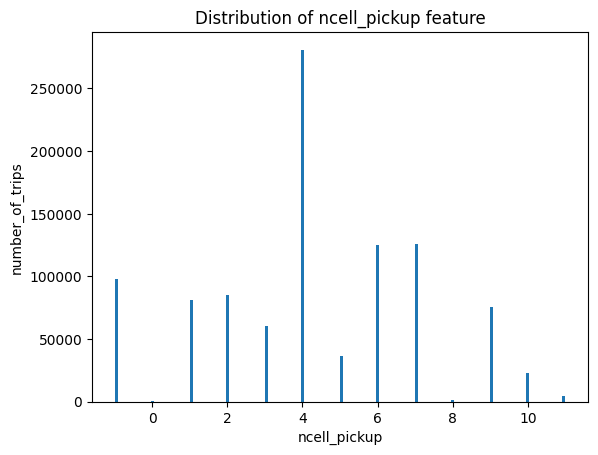

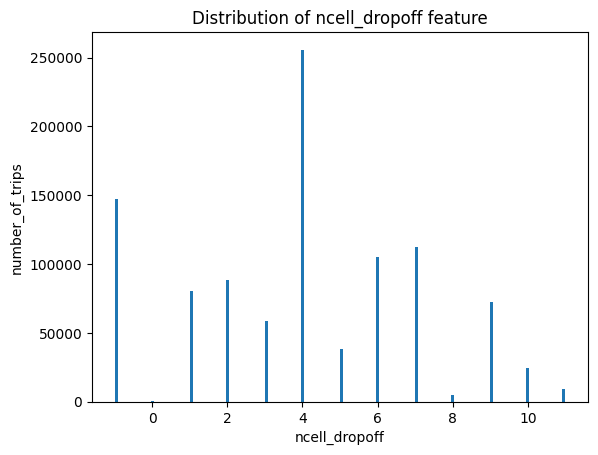

In [52]:
# Не имеет смысла рассматривать бинарные категориальные признаки (там редкие категории и так объединены в 1)
non_binary_categorical_features = ['day_of_week', 'month', 'hour', 'day_of_year', 'ncell_pickup', 'ncell_dropoff']

for feature in non_binary_categorical_features:
    plt.hist(train[f'{feature}'], bins='auto')
    plt.xlabel(f'{feature}')
    plt.ylabel('number_of_trips')
    plt.title(f'Distribution of {feature} feature')
    plt.show()

Как видно из графиков, все значения небинарных категорий, кроме значений 0, 8 и 11 для категорий ncell_pickup и ncell_dropoff встречаются достаточно часто, так что в них нечего объединять

In [61]:
train.loc[(train['ncell_pickup']) == 0 | (train['ncell_pickup'] == 8) | (train['ncell_pickup'] == 11),
          'ncell_pickup'] = 13
train.loc[(train['ncell_dropoff']) == 0 | (train['ncell_dropoff'] == 8) | (train['ncell_dropoff'] == 11),
          'ncell_dropoff'] = 13
test.loc[(test['ncell_pickup']) == 0 | (test['ncell_pickup'] == 8) | (test['ncell_pickup'] == 11),
          'ncell_pickup'] = 13
test.loc[(test['ncell_dropoff']) == 0 | (test['ncell_dropoff'] == 8) | (test['ncell_dropoff'] == 11),
          'ncell_dropoff'] = 13

In [62]:
train.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'log_trip_duration', 'day_of_week', 'month', 'hour', 'is_first_anomaly',
       'is_second_anomaly', 'day_of_year', 'haversine', 'log_haversine',
       'is_free_roads_period', 'is_jam_period', 'pickup_lowest_cluster',
       'dropoff_lowest_cluster', 'pickup_first_right_cluster',
       'dropoff_first_right_cluster', 'pickup_second_right_cluster',
       'dropoff_second_right_cluster', 'ncell_pickup', 'ncell_dropoff'],
      dtype='object')

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [65]:
X_train = train.drop(labels=['log_trip_duration'], axis=1).copy()
X_test = test.drop(labels=['log_trip_duration'], axis=1).copy()
Y_train = train['log_trip_duration']
Y_test = test['log_trip_duration']
categorical = ['day_of_week', 'month', 'day_of_year', 'hour', 'ncell_pickup', 'ncell_dropoff']
numeric_features = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
                    'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
                    'is_first_anomaly', 'is_second_anomaly', 'haversine',
                    'log_haversine',
                    'is_free_roads_period', 'is_jam_period', 'pickup_lowest_cluster',
                    'dropoff_lowest_cluster', 'pickup_first_right_cluster', 'dropoff_first_right_cluster',
                    'pickup_second_right_cluster', 'dropoff_second_right_cluster']

'''
Здесь я добавил 'vendor_id', 'store_and_fwd_flag', 'is_first_anomaly', 'is_second_anomaly',
'haversine', 'log_haversine',
'is_free_roads_period', 'is_jam_period', 'pickup_lowest_cluster', 'dropoff_lowest_cluster',
'pickup_first_right_cluster', 'dropoff_first_right_cluster', 'pickup_second_right_cluster',
'dropoff_second_right_cluster'
в массив категориальных признаков, поскольку к ним уже применено OHE
'''

column_transformer = ColumnTransformer ([
    ('ohe', OneHotEncoder (handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
pipeline = Pipeline(steps=[
(' ohe_and_scaling', column_transformer),
(' regression', Ridge())
])

model = pipeline.fit(X_train, Y_train)
y_pred = model.predict(X_test)
print(f'RMSLE: {rmsle(Y_test, y_pred)}')

RMSLE: 0.48236254339133766


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [66]:
ohe_col_trans = ColumnTransformer ([
    ('ohe', OneHotEncoder (handle_unknown="ignore"), categorical)
])
X_transformed = ohe_col_trans.fit_transform(X_train)
print(f'Initial number of features: {len(X_train.columns)}')
print(f'Number of features after OHE: {len(ohe_col_trans.get_feature_names_out()) + len(numeric_features)}')

Initial number of features: 25
Number of features after OHE: 264


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [67]:
X_train = train.drop(labels=['log_trip_duration'], axis=1).copy()
X_test = test.drop(labels=['log_trip_duration'], axis=1).copy()
Y_train = train['log_trip_duration']
Y_test = test['log_trip_duration']
categorical = ['day_of_week', 'month', 'day_of_year', 'hour', 'ncell_pickup', 'ncell_dropoff']
numeric_features = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
                    'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
                    'is_first_anomaly', 'is_second_anomaly', 'haversine',
                    'log_haversine',
                    'is_free_roads_period', 'is_jam_period', 'pickup_lowest_cluster',
                    'dropoff_lowest_cluster', 'pickup_first_right_cluster', 'dropoff_first_right_cluster',
                    'pickup_second_right_cluster', 'dropoff_second_right_cluster']

'''
Здесь я добавил 'vendor_id', 'store_and_fwd_flag', 'is_first_anomaly', 'is_second_anomaly',
'haversine', 'log_haversine',
'is_free_roads_period', 'is_jam_period', 'pickup_lowest_cluster', 'dropoff_lowest_cluster',
'pickup_first_right_cluster', 'dropoff_first_right_cluster', 'pickup_second_right_cluster',
'dropoff_second_right_cluster'
в массив категориальных признаков, поскольку к ним уже применено OHE
'''

column_transformer = ColumnTransformer ([
    ('ohe', OneHotEncoder (handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
pipeline = Pipeline(steps=[
(' ohe_and_scaling', column_transformer),
(' regression', Lasso())
])

model = pipeline.fit(X_train, Y_train)
y_pred = model.predict(X_test)
print(f'RMSLE: {rmsle(Y_test, y_pred)}')

RMSLE: 0.7966332429762087


Ridge лучше

Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [68]:
train, val = sklearn.model_selection.train_test_split(train, test_size=0.2, train_size=0.8,
                                                       random_state=sklearn_rnd_state)
X_val = val.drop(labels=['log_trip_duration'], axis=1)
Y_val = val['log_trip_duration']

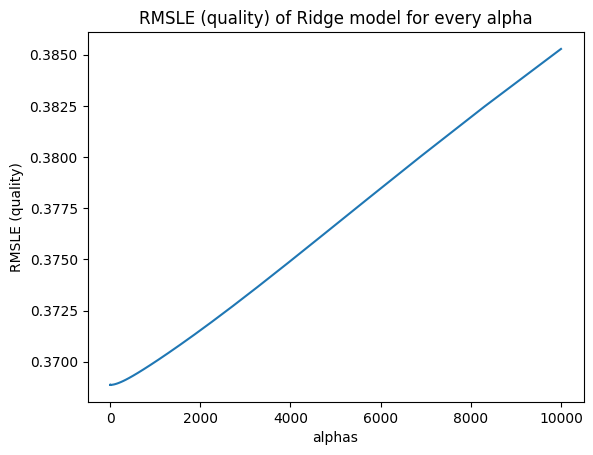

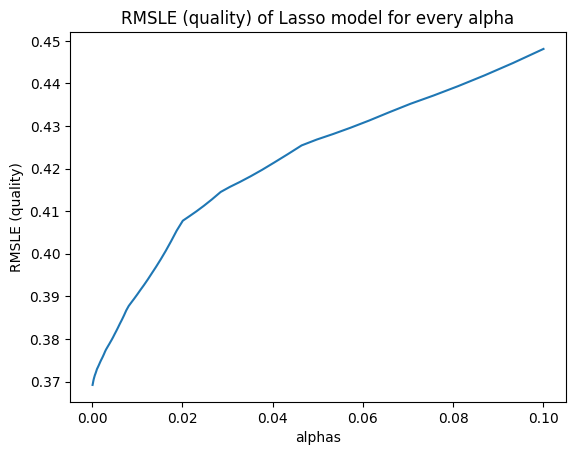

In [80]:
alphas_Ridge = np.logspace(-4, 4, 100)
alphas_Lasso = np.logspace(-4, -1, 100)
quality_Ridge = []
quality_Lasso = []
num_of_zero_coef_Lasso = []

column_transformer = ColumnTransformer ([
('ohe', OneHotEncoder (handle_unknown="ignore"), categorical),
('scaling', StandardScaler(), numeric_features)
])

for value in alphas_Ridge:
    pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(alpha=value))
    ])
    model = pipeline.fit(X_val, Y_val)
    quality_Ridge.append(rmsle(Y_val, model.predict(X_val)))

plt.title(f'RMSLE (quality) of Ridge model for every alpha')
plt.plot(alphas_Ridge, quality_Ridge)
plt.xlabel('alphas')
plt.ylabel('RMSLE (quality)')
plt.show()

for value in alphas_Lasso:
    pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(alpha=value))
    ])
    model = pipeline.fit(X_val, Y_val)
    (num_of_zero_coef_Lasso
     .append(model['regression'].sparse_coef_.shape[1] - len(model['regression'].sparse_coef_.data))
    )
    quality_Lasso.append(rmsle(Y_val, model.predict(X_val)))

plt.title(f'RMSLE (quality) of Lasso model for every alpha')
plt.plot(alphas_Lasso, quality_Lasso)
plt.xlabel('alphas')
plt.ylabel('RMSLE (quality)')
plt.show()


In [92]:
best_alpha_Ridge = alphas_Ridge[np.argmin(quality_Ridge)]
best_alpha_Lasso = alphas_Lasso[np.argmin(quality_Lasso)]

In [93]:
X_train = train.drop(labels=['log_trip_duration'], axis=1).copy()
X_test = test.drop(labels=['log_trip_duration'], axis=1).copy()
Y_train = train['log_trip_duration']
Y_test = test['log_trip_duration']
categorical = ['day_of_week', 'month', 'day_of_year', 'hour', 'ncell_pickup', 'ncell_dropoff']
numeric_features = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
                    'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
                    'is_first_anomaly', 'is_second_anomaly', 'haversine',
                    'log_haversine',
                    'is_free_roads_period', 'is_jam_period', 'pickup_lowest_cluster',
                    'dropoff_lowest_cluster', 'pickup_first_right_cluster', 'dropoff_first_right_cluster',
                    'pickup_second_right_cluster', 'dropoff_second_right_cluster',
                   ]

'''
Здесь я добавил 'vendor_id', 'store_and_fwd_flag', 'is_first_anomaly', 'is_second_anomaly',
'haversine', 'log_haversine',
'is_free_roads_period', 'is_jam_period', 'pickup_lowest_cluster', 'dropoff_lowest_cluster',
'pickup_first_right_cluster', 'dropoff_first_right_cluster', 'pickup_second_right_cluster',
'dropoff_second_right_cluster'
в массив категориальных признаков, поскольку к ним уже применено OHE
'''

column_transformer = ColumnTransformer ([
    ('ohe', OneHotEncoder (handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
pipeline = Pipeline(steps=[
(' ohe_and_scaling', column_transformer),
(' regression', Ridge(alpha=best_alpha_Ridge))
])

model = pipeline.fit(X_train, Y_train)
y_pred = model.predict(X_test)
ridge_rmsle = rmsle(Y_test, y_pred)
print(f'Ridge RMSLE: {rmsle(Y_test, y_pred)}')

Ridge RMSLE: 0.48226773723172345


In [94]:
X_train = train.drop(labels=['log_trip_duration'], axis=1).copy()
X_test = test.drop(labels=['log_trip_duration'], axis=1).copy()
Y_train = train['log_trip_duration']
Y_test = test['log_trip_duration']
categorical = ['day_of_week', 'month', 'day_of_year', 'hour', 'ncell_pickup', 'ncell_dropoff']
numeric_features = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
                    'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
                    'is_first_anomaly', 'is_second_anomaly', 'haversine',
                    'log_haversine',
                    'is_free_roads_period', 'is_jam_period', 'pickup_lowest_cluster',
                    'dropoff_lowest_cluster', 'pickup_first_right_cluster', 'dropoff_first_right_cluster',
                    'pickup_second_right_cluster', 'dropoff_second_right_cluster']

'''
Здесь я добавил 'vendor_id', 'store_and_fwd_flag', 'is_first_anomaly', 'is_second_anomaly',
'haversine', 'log_haversine',
'is_free_roads_period', 'is_jam_period', 'pickup_lowest_cluster', 'dropoff_lowest_cluster',
'pickup_first_right_cluster', 'dropoff_first_right_cluster', 'pickup_second_right_cluster',
'dropoff_second_right_cluster'
в массив категориальных признаков, поскольку к ним уже применено OHE
'''

column_transformer = ColumnTransformer ([
    ('ohe', OneHotEncoder (handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
pipeline = Pipeline(steps=[
(' ohe_and_scaling', column_transformer),
(' regression', Lasso(alpha=best_alpha_Lasso))
])

model = pipeline.fit(X_train, Y_train)
y_pred = model.predict(X_test)
lasso_rmsle = rmsle(Y_test, y_pred)
print(f'Lasso RMSLE: {rmsle(Y_test, y_pred)}')

Lasso RMSLE: 0.48244559356710226


Сохраните наилучшее значение, как бенчмарк на будущее

In [95]:
best_rmsle = min(ridge_rmsle, lasso_rmsle)
print(best_rmsle)

0.48226773723172345


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?\
Если избавиться хотя бы от половины признаков, RMSLE увеличится минимум на 0.01-0.02

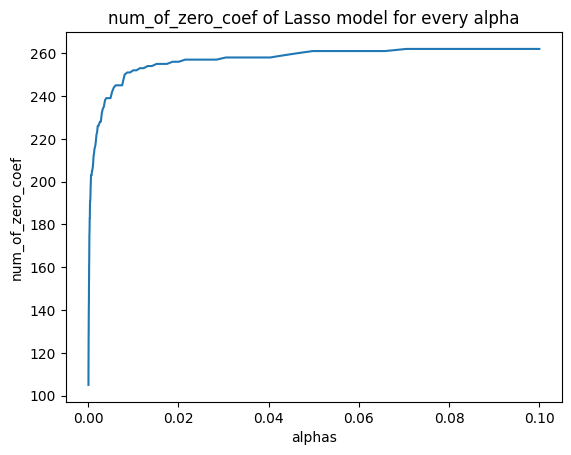

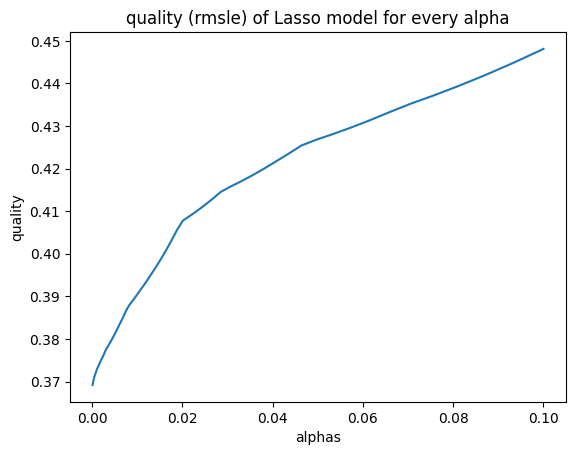

In [91]:
plt.plot(alphas_Lasso, num_of_zero_coef_Lasso)
plt.xlabel('alphas')
plt.ylabel('num_of_zero_coef')
plt.title('num_of_zero_coef of Lasso model for every alpha')
plt.show()

plt.plot(alphas_Lasso, quality_Lasso)
plt.xlabel('alphas')
plt.ylabel('quality')
plt.title('quality (rmsle) of Lasso model for every alpha')
plt.show()

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

Ответ был частично сгенерирован с помощью GPT. Промптом служило само задание. Запрос был сделан в диалоге, где я задавал предыдущие вопросы по этому ДЗ.

Такой признак потенциально полезен, потому что он кодирует взаимодействие двух исходных признаков (начальная и конечная ячейки) в виде одной новой категории.

Линейная модель, как правило, работает с каждым признаком отдельно, без учета их взаимодействий. То есть она может учесть влияние начальной и конечной ячеек по отдельности, но не способна легко "вытащить" информацию о том, что определённые комбинации (взаимодействия) этих ячеек могут иметь особое значение для предсказания. Взаимодействие двух признаков часто оказывается нелинейным, и линейная модель просто не может выразить такие зависимости напрямую.

Когда мы добавляем взаимодействия признаков как новый категориальный признак, мы помогаем модели "заметить" такие нелинейные зависимости. Примером может быть то, что определённая пара ячеек (например, поездки между определёнными районами Манхэттена) может быть гораздо более популярной или значимой, чем другие. Линейная модель, имея доступ только к отдельным ячейкам, не сможет учесть эту специфичность, если не будет явного взаимодействия между этими признаками.

In [96]:
for selection in [train, val, test]:
    cell_features = selection[['ncell_pickup', 'ncell_dropoff']]
    selection['cell_pair'] = selection[['ncell_pickup', 'ncell_dropoff']].values.tolist()
    selection['cell_pair'] = selection['cell_pair'].apply(tuple)
    top_100_freq_pairs = list(cell_features
                              .groupby(by=['ncell_pickup', 'ncell_dropoff'])
                              .value_counts()
                              .sort_values()[-100:]
                              .index
                              .values)
    
    def index_with_default_value(l, value):
        try:
            idx = l.index(value)
            return idx
        except:
            return -1
    
    selection['cell_pair'] = (selection['cell_pair']
                              .apply(lambda value : index_with_default_value(top_100_freq_pairs, value)))

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [97]:
X_train = train.drop(labels=['log_trip_duration'], axis=1).copy()
X_test = test.drop(labels=['log_trip_duration'], axis=1).copy()
Y_train = train['log_trip_duration']
Y_test = test['log_trip_duration']
categorical = ['day_of_week', 'month', 'day_of_year', 'hour', 'ncell_pickup', 'ncell_dropoff', 'cell_pair']
numeric_features = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
                    'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
                    'is_first_anomaly', 'is_second_anomaly', 'haversine',
                    'log_haversine',
                    'is_free_roads_period', 'is_jam_period', 'pickup_lowest_cluster',
                    'dropoff_lowest_cluster', 'pickup_first_right_cluster', 'dropoff_first_right_cluster',
                    'pickup_second_right_cluster', 'dropoff_second_right_cluster',
                   ]

'''
Здесь я добавил 'vendor_id', 'store_and_fwd_flag', 'is_first_anomaly', 'is_second_anomaly',
'haversine', 'log_haversine',
'is_free_roads_period', 'is_jam_period', 'pickup_lowest_cluster', 'dropoff_lowest_cluster',
'pickup_first_right_cluster', 'dropoff_first_right_cluster', 'pickup_second_right_cluster',
'dropoff_second_right_cluster'
в массив категориальных признаков, поскольку к ним уже применено OHE
'''

column_transformer = ColumnTransformer ([
    ('ohe', OneHotEncoder (handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
pipeline = Pipeline(steps=[
(' ohe_and_scaling', column_transformer),
(' regression', Ridge(alpha=best_alpha_Ridge))
])

model = pipeline.fit(X_train, Y_train)
y_pred = model.predict(X_test)
ridge_rmsle = rmsle(Y_test, y_pred)
print(f'Ridge RMSLE: {rmsle(Y_test, y_pred)}')

Ridge RMSLE: 0.5261494813018671


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**.

Разумеется, погружаться в feature engineering можно ещё очень долго. Ваша задача - придумать какие-то новые признаки, которые сделают модель ещё лучше!! За улучшение функционала ошибки на каждые 0.005 на тестовой выборке относительно `best_rmsle` будет даваться 0.5 бонусных балла. Всего за этот пункт можно получить до 2 бонусных баллов.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Какие могут быть идеи для вдохновения:

1. Трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения, по аналогии с квадратной сеткой  
> Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.    

2. Мы пока что никак не использовали историчность и взаимосвязь в данных, хотя информация о том, что было ранее в эти/похожие дни тоже может пригодиться. Попробуйте поискать соседей и/или построить агрегации, например, при помощи groupby, посчитайте какие-либо статистики в пределах какого-то окна (подберите всё это сами, постарайтесь, чтобы это было что-то разумное), и присоедините к основному датафрейму
> Важно: учтите, что разных вариантов агрегаций и статистик существует очень много. Не стесняйтесь выкидывать фичи, которые вам не нравятся (помните про свойство Lasso), используйте эффективные способы хранения данных ([wink](https://www.kaggle.com/code/demche/polars-memory-usage-optimization)-[wink](https://docs.scipy.org/doc/scipy/reference/sparse.html))

3. В конце концов можно использовать альтернативные способы преобразования данных. Например, использовать другой scaler, другую кодировку категориальных фичей, другие гиперпараметры и пр. Но помните, что на данный момент мы ограничены только `Ridge` и `Lasso`

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.